# Deep Learning Project
# A.A 2021/2022
# Student: Donato Francesco Pio Stanco 2027523

## Group Equivariant Convolutional Networks

Group equivariant Convolutional Neural Networks (**G-CNNs**), are a natural generalization of *convolutional neural networks* that reduces sample complexity by exploiting symmetries.

An example of this kind of network is provided in the following image, where we can observe a **p4m feature map and its rotation by r**.

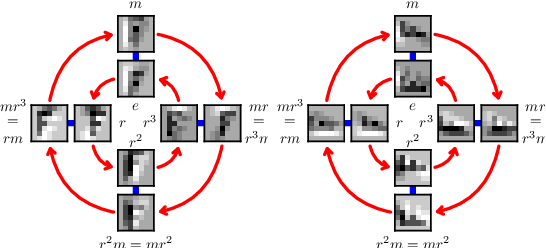

## Experiment with Rotated MNIST

Scrivici che tipo di gruppo viene utilizzato (p4m) e qualche altra cosa introduttiva.

In [ ]:
# Here I do the git clone of two repositories, the first one contains the G-CNN 
# experiments and the second one is my personal repository for this project
!git clone https://github.com/adambielski/GrouPy.git
!git clone https://github.com/dstanco98/DeepLearningProject.git

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 167 (delta 35), reused 33 (delta 33), pack-reused 119
Receiving objects: 100% (167/167), 141.59 KiB | 2.62 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Cloning into 'DeepLearningProject'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 62 (delta 7), reused 36 (delta 0), pack-reused 4
Unpacking objects: 100% (62/62), done.


In [ ]:
%cd GrouPy/
!python setup.py install
%cd ..

/content/GrouPy
running install
running build
running build_py
creating build
creating build/lib
creating build/lib/groupy
copying groupy/__init__.py -> build/lib/groupy
creating build/lib/groupy/garray
copying groupy/garray/finitegroup.py -> build/lib/groupy/garray
copying groupy/garray/matrix_garray.py -> build/lib/groupy/garray
copying groupy/garray/test_garray.py -> build/lib/groupy/garray
copying groupy/garray/garray.py -> build/lib/groupy/garray
copying groupy/garray/p4m_array.py -> build/lib/groupy/garray
copying groupy/garray/D4_array.py -> build/lib/groupy/garray
copying groupy/garray/p4_array.py -> build/lib/groupy/garray
copying groupy/garray/Z2_array.py -> build/lib/groupy/garray
copying groupy/garray/C4_array.py -> build/lib/groupy/garray
copying groupy/garray/__init__.py -> build/lib/groupy/garray
creating build/lib/groupy/gconv
copying groupy/gconv/make_gconv_indices.py -> build/lib/groupy/gconv
copying groupy/gconv/__init__.py -> build/lib/groupy/gconv
creating build/li

In [ ]:
# Here we have useful imports for the experiment
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable

In [ ]:
# In this cell we download the dataset MNIST for training and testing

trainset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation((90, 270)),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
testset = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.RandomRotation((90, 270)),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


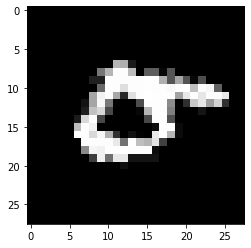

Label: 9


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In the following cells I readapt the code provided in the description of the project, in order to made it reasable for the purpose required.



In [ ]:
# Here are useful imports for using G-CNN

from groupy.gconv.pytorch_gconv.splitgconv2d import P4ConvZ2, P4ConvP4
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = P4ConvZ2(1, 10, kernel_size=3)
        self.conv2 = P4ConvP4(10, 10, kernel_size=3)
        self.conv3 = P4ConvP4(10, 20, kernel_size=3)
        self.conv4 = P4ConvP4(20, 20, kernel_size=3)
        self.fc1 = nn.Linear(4*4*20*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
log_freq = 10

# This is the train function used to train the model
def train(epoch, optimizer, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# This is the test function used to test the model
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

As known a Deep Learning algorithm is divided into two main phases:
- Training phase
- Testing phase

So, In the next cell I do the **training** of the model and I set the number of epochs equals to **60** that is a number represents a tradeoff in order to obtain a good model

Since the entire process does not take too much time I decide to use the **GPU** provided by *Google Colab* and the entire process takes around *37 minutes* of execution.

In [ ]:
from tqdm.notebook import tqdm

run_training = True  #@param {type:"boolean"}
SAVE_PATH = '/content/DeepLearningProject/RotatedMNIST/'
PATH = SAVE_PATH + 'ckp.pt'
epoch_number = 60
test_freq = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

if run_training:
      net = Net()
      net.to(device)
      learning_rate = 0.01
      momentum = 0.5
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
        
      for i in tqdm(range(epoch_number)):
          net.train()
          train(i, optimizer, net)

          if (i+1) % test_freq == 0:
            print('\n-------------Network Test-------------')
            net.eval()
            test(net)
            print('----------------------------------------\n')
      torch.save(net.state_dict(), PATH)
                    

cuda:0


  0%|          | 0/60 [00:00<?, ?it/s]

Output streaming troncato alle ultime 5000 righe.
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.458424
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.050385
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.046791
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.279305
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.115302
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.108920
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.076266
Train Epoch: 7 [42240/60000 (70%)]	Loss: 0.084871
Train Epoch: 7 [42880/60000 (71%)]	Loss: 0.230366
Train Epoch: 7 [43520/60000 (72%)]	Loss: 0.067752
Train Epoch: 7 [44160/60000 (74%)]	Loss: 0.125950
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.126868
Train Epoch: 7 [45440/60000 (76%)]	Loss: 0.281863
Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.091891
Train Epoch: 7 [46720/60000 (78%)]	Loss: 0.060610
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.059509
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.111394
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.126621
Train Epoch: 7 [49280/60000 (82%)]	Loss: 0.134814


If we used CPU to train our model and not GPU we have to specify the parameter *map_location* after the path of our model. But for this type of scope it is appropriate to use GPU.



The next step is to make the **testing phase** of the model trained before, and then check for the results obtained.

In [ ]:
model = Net()
# here we load the model trained before
model.load_state_dict(torch.load('/content/DeepLearningProject/RotatedMNIST/ckp.pt'))
model = model.to(device)

In [ ]:
model.train() # call the train function defined in the Net class
test(model) # test of the model 


Test set: Average loss: 0.0527, Accuracy: 9859/10000 (99%)



In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
with torch.no_grad():
  output = model(example_data.to(device))

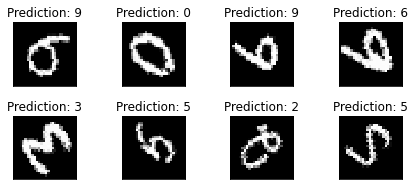

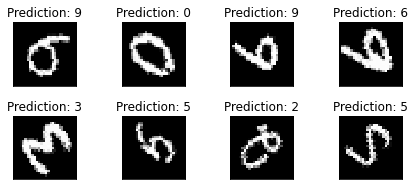

In [ ]:
# Here I decided to do some plot in order to understand if the predictions made 
# by the model were correct.

fig = plt.figure()
for i in range(8):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

From the plot above we can observe that the model's predictions are correct, and also we can observe the power of this type of Nework also with the rotated inputs.